# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) 
# Project 4: Web Scraping Job Postings

## Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal has two main objectives:

   1. Determine the industry factors that are most important in predicting the salary amounts for these data.
   2. Determine the factors that distinguish job categories and titles from each other. For example, can required skills accurately predict job title?

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries. 

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer these two questions.


# Job scrapping

1. Job are scraped from mycareerfutures.sg
2. Job searched with keyword data
3. The job scrapping code can be found in the folder datajob
4. Totally 4000+ jobs are scrapted
5. To match the scope of the project, kept 1000+ jobs that can be determined as data related job from their job title


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import RidgeCV, LassoCV, HuberRegressor, LogisticRegressionCV, LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from textblob import TextBlob
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import SMOTE
import seaborn as sns
import pickle
%matplotlib inline
sns.set_style('white')

In [2]:
# load the job scraped from mycareerfuture.sg
job_post = pd.read_csv('D:\GA\project_submission\project-4\datajob\datajob\datajob_0430_250pages.csv')
job_post.head(3)

,company_name,job_categories,job_experience,job_level,job_link,job_location,job_requirement,job_role_resp,job_salaries_max,job_salaries_min,job_salaries_type,job_skills,job_title,job_type
0,NTT DATA SINGAPORE PTE. LTD.,"Banking and Finance, Information Technology",NaN,"Manager, Professional",https://www.mycareersfuture.sg/job/project-man...,"KEPPEL TOWERS, 10 HOE CHIANG ROAD 089315","Project management,/Scrum Master/Business Anal...",We are looking for versatile project manager w...,"$9,200","$7,500",Monthly,"Budgets,Business Analysis,Business Development...",Project Manager- Data Security,Contract
1,NTUC ENTERPRISE CO-OPERATIVE LTD,"Education and Training, Information Technology",NaN,Middle Management,https://www.mycareersfuture.sg/job/vice-presid...,NaN,Must be highly technical/strong hardware and s...,"COMPANY DESCRIPTION,NTUC Enterprise is the hol...","$13,000","$8,000",Monthly,"Business Analysis,Business Intelligence,Data A...","Vice President, Enterprise Data Warehouse",Full Time
2,BIOFOURMIS SINGAPORE PTE. LTD.,Engineering,NaN,Senior Executive,https://www.mycareersfuture.sg/job/big-data-en...,"VISION EXCHANGE, 2 VENTURE DRIVE 608526","~,Advanced working SQL knowledge and experienc...",We are looking for a savvy Data Engineer to jo...,"$6,700","$5,200",Monthly,"Agile Methodologies,C#,C++,HTML,Integration,Ja...",Big Data Engineer,Permanent


In [3]:
job_post.shape

(4013, 14)

In [4]:
# checking missing data point
job_post.isnull().sum()

company_name           21
job_categories          3
job_experience       3752
job_level              21
job_link                0
job_location          676
job_requirement       108
job_role_resp           0
job_salaries_max        0
job_salaries_min        0
job_salaries_type       0
job_skills              0
job_title              18
job_type               12
dtype: int64

In [5]:
# remove the data without title, without requirement of experience
job_post.drop(index=job_post[job_post.job_title.isnull()].index, inplace=True)
job_post.drop(index=job_post[job_post.job_level.isnull()].index, inplace=True)

In [6]:
job_post.isnull().sum()

company_name            3
job_categories          0
job_experience       3721
job_level               0
job_link                0
job_location          662
job_requirement        95
job_role_resp           0
job_salaries_max        0
job_salaries_min        0
job_salaries_type       0
job_skills              0
job_title               0
job_type                0
dtype: int64

In [7]:
job_post.job_salaries_type.value_counts()

Monthly     3852
Annually     130
Name: job_salaries_type, dtype: int64

In [8]:
job_post.job_salaries_min = job_post.job_salaries_min.map(lambda x: int(x[1:].replace(',', '')))
job_post.job_salaries_max = job_post.job_salaries_max.map(lambda x: int(x[1:].replace(',', '')))

job_post.loc[job_post.job_salaries_type=='Annually',['job_salaries_min', 'job_salaries_max']] = job_post.loc[job_post.job_salaries_type=='Annually',['job_salaries_min', 'job_salaries_max']]/12        
job_post['job_salaries_mean'] = (job_post.job_salaries_min + job_post.job_salaries_max)/2
job_post['job_salaries_range'] = (job_post.job_salaries_max - job_post.job_salaries_min)

In [9]:
job_post.drop_duplicates(keep='first', inplace=True)
job_post.reset_index(drop=True, inplace=True)

In [10]:
job_post.shape

(3970, 16)

## Label job title

In [11]:
title_stop = list(ENGLISH_STOP_WORDS)
title_stop.extend(['3000', '3500', '4000', 'days', 'contract', '1-year', 'orchard', 
                   'west', 'central', 'week', 'year','i2r','star', 'months','workday', 
                   'day', 'shift', 'ot', 'joo', 'koon', 'years','xaxis','workforce'])

In [12]:
# lemmatizer = WordNetLemmatizer()
# stemmer = PorterStemmer()
# # lemmatized_title= job_post.job_title.map(lambda x: ' '.join([stemmer.stem(w) for w in TextBlob(x.lower()).words]))

In [13]:
countVect = CountVectorizer(ngram_range=(2,3), stop_words=title_stop, token_pattern=r'\b[^\d\W_]+\b', min_df=max(int(len(job_post)/300), 5))
countVect.fit(job_post.job_title)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=13,
        ngram_range=(2, 3), preprocessor=None,
        stop_words=['elsewhere', 'everything', 'except', 'hence', 'whither', 'due', 'yourselves', 'ie', 'seeming', 'than', 'yourself', 'must', 'twenty', 'should', 'themselves', 'seemed', 'where', 'below', 'anyone', 'less', 'i', 'therein', 'done', 'perhaps', 'when', 'eg', 'beside', 'yours', 'con', 'from', 'n...r', 'star', 'months', 'workday', 'day', 'shift', 'ot', 'joo', 'koon', 'years', 'xaxis', 'workforce'],
        strip_accents=None, token_pattern='\\b[^\\d\\W_]+\\b',
        tokenizer=None, vocabulary=None)

In [14]:
# take a look of the high popular job key words
pd.DataFrame(countVect.transform(job_post.job_title).todense(), columns=countVect.get_feature_names()).sum(axis=0).sort_values(ascending=False).head(60)

software engineer           96
data scientist              89
data engineer               82
project manager             65
business analyst            63
research fellow             61
data analyst                52
product manager             49
admin assistant             48
senior manager              48
data analytics              48
account manager             48
research engineer           45
big data                    43
accounts executive          41
assistant manager           38
senior software             36
marketing manager           36
t o                         36
customer service            35
research associate          34
technology operations       32
senior engineer             31
network engineer            31
accounts assistant          30
senior executive            28
research assistant          28
senior data                 27
operations executive        27
software developer          26
admin executive             25
vice president              24
senior s

In [15]:
job_post['job_label'] = np.nan

In [16]:
# takindata_entryg all researchers
job_post.loc[job_post.job_title.str.lower().str.contains('research'), 'job_label'] = 'Research'

In [17]:
# take data scientist with the following keywords, if labeled before do not label again
job_post.loc[job_post.job_title.str.lower().str.contains('data scientist') & job_post.job_label.isnull(), 'job_label'] = 'data_scientist'
job_post.loc[job_post.job_title.str.lower().str.contains('data science') & job_post.job_label.isnull(), 'job_label'] = 'data_scientist'
job_post.loc[job_post.job_title.str.lower().str.contains('machine learning') & job_post.job_label.isnull(), 'job_label'] = 'data_scientist'


In [18]:
# solution architect 
job_post.loc[job_post.job_title.str.lower().str.contains('architect') & job_post.job_label.isnull(), 'job_label'] = 'solution_architect'
job_post.loc[job_post.job_title.str.lower().str.contains('architecture') & job_post.job_label.isnull(), 'job_label'] = 'solution_architect'
job_post.loc[job_post.job_title.str.lower().str.contains('solution') & job_post.job_label.isnull(), 'job_label'] = 'solution_architect'


In [19]:
# take data enginner with the following keywords
job_post.loc[job_post.job_title.str.lower().str.contains('data engineer') & job_post.job_label.isnull(), 'job_label'] = 'data_engineer'
job_post.loc[job_post.job_title.str.lower().str.contains('data engineering') & job_post.job_label.isnull(), 'job_label'] = 'data_engineer'
job_post.loc[job_post.job_title.str.lower().str.contains('data migration') & job_post.job_label.isnull(), 'job_label'] = 'data_engineer'
job_post.loc[job_post.job_title.str.lower().str.contains('security') & job_post.job_label.isnull(), 'job_label'] = 'data_engineer'
job_post.loc[job_post.job_title.str.lower().str.contains('cloud') & job_post.job_label.isnull(), 'job_label'] = 'data_engineer'
job_post.loc[job_post.job_title.str.lower().str.contains('system engineer') & job_post.job_label.isnull(), 'job_label'] = 'data_engineer'
job_post.loc[job_post.job_title.str.lower().str.contains('network engineer') & job_post.job_label.isnull(), 'job_label'] = 'data_engineer'




In [20]:
# take analyst job with the following keywords

job_post.loc[job_post.job_title.str.lower().str.contains('data analytics') & job_post.job_label.isnull(), 'job_label'] = 'data_analyst'
job_post.loc[job_post.job_title.str.lower().str.contains('data analyst') & job_post.job_label.isnull(), 'job_label'] = 'data_analyst'
job_post.loc[job_post.job_title.str.lower().str.contains('data analysis') & job_post.job_label.isnull(), 'job_label'] = 'data_analyst'

# data_analyst = job_post[job_post.job_title.str.lower().str.contains('data analytics')]
# data_analyst = pd.concat([data_analyst,job_post[job_post.job_title.str.lower().str.contains('data analyst')]])
# data_analyst = pd.concat([data_analyst,job_post[job_post.job_title.str.lower().str.contains('data analysis')]])
# data_analyst.drop_duplicates(keep='first', inplace=True)


# data_analyst.shape

In [21]:
# taking all other analysis as other analyst

job_post.loc[job_post.job_title.str.lower().str.contains('analyst') & job_post.job_label.isnull(), 'job_label'] = 'other_analyst'
job_post.loc[job_post.job_title.str.lower().str.contains('analysis') & job_post.job_label.isnull(), 'job_label'] = 'other_analyst'
job_post.loc[job_post.job_title.str.lower().str.contains('analytics') & job_post.job_label.isnull(), 'job_label'] = 'other_analyst'


In [22]:
# taking all other analysis as other analyst
job_post.loc[job_post.job_title.str.lower().str.contains('data entry') & job_post.job_label.isnull(), 'job_label'] = 'entry'


In [23]:
job_post.job_label.value_counts()

other_analyst         288
data_engineer         238
Research              236
solution_architect    123
data_scientist        119
data_analyst           81
entry                  14
Name: job_label, dtype: int64

In [24]:
q1_jobs = job_post[job_post.job_label.notnull()]

In [25]:
salary_mean = q1_jobs.job_salaries_mean.median()

In [26]:
salary_mean_std = q1_jobs.job_salaries_mean.std()

In [27]:
middle_salary = [(salary_mean - salary_mean_std/2), (salary_mean + salary_mean_std/2)]

In [28]:
middle_salary

[4300.015609448624, 7699.984390551376]

In [29]:
q1_jobs['salary_cate'] = np.nan

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [30]:
def salary_to_cate(x, middle_salary = middle_salary ):
    if x<middle_salary[0]:
        return 0
    elif x<middle_salary[1]:
        return 1
    else:
        return 2

In [31]:
q1_jobs.salary_cate = q1_jobs.job_salaries_mean.map(salary_to_cate)

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [32]:
q1_jobs.salary_cate.value_counts()

1    510
2    322
0    267
Name: salary_cate, dtype: int64

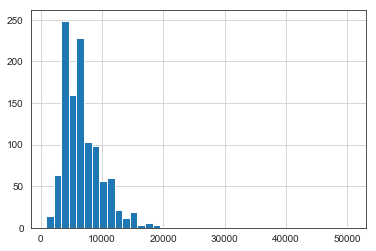

In [33]:
q1_jobs.job_salaries_mean.hist(bins=40)

### QUESTION 1: Factors that impact salary

To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary).

You have learned a variety of new skills and models that may be useful for this problem:
- NLP
- Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
- Ensemble methods and decision tree models
- SVM models

Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.

In [34]:
q1_jobs.columns

Index(['company_name', 'job_categories', 'job_experience', 'job_level',
       'job_link', 'job_location', 'job_requirement', 'job_role_resp',
       'job_salaries_max', 'job_salaries_min', 'job_salaries_type',
       'job_skills', 'job_title', 'job_type', 'job_salaries_mean',
       'job_salaries_range', 'job_label', 'salary_cate'],
      dtype='object')

In [35]:
q1_jobs.isnull().sum()

company_name             0
job_categories           0
job_experience        1033
job_level                0
job_link                 0
job_location           198
job_requirement         39
job_role_resp            0
job_salaries_max         0
job_salaries_min         0
job_salaries_type        0
job_skills               0
job_title                0
job_type                 0
job_salaries_mean        0
job_salaries_range       0
job_label                0
salary_cate              0
dtype: int64

The choosen features are: job_categories, job_level, job_skills, job_label, job_type

In [36]:
q1_jobs.groupby(['job_label']).mean().sort_values(by='job_salaries_max')

,job_salaries_max,job_salaries_min,job_salaries_mean,job_salaries_range,salary_cate
job_label,,,,,
entry,2021.428571,1500.000000,1760.714286,521.428571,0.000000
Research,6653.735876,3886.539548,5270.137712,2767.196328,0.622881
data_engineer,8346.158263,5210.840336,6778.499300,3135.317927,1.033613
data_analyst,8381.728395,5288.135802,6834.932099,3093.592593,1.086420
other_analyst,8396.829861,5359.280093,6878.054977,3037.549769,1.090278
data_scientist,9782.408964,6132.997199,7957.703081,3649.411765,1.369748
solution_architect,11122.178862,6872.894309,8997.536585,4249.284553,1.593496


In [37]:
class MyTokenizer(object):
    def __call__(self,s):
        return  [WordNetLemmatizer().lemmatize(ele.strip()) for ele in s.split(',')]


In [38]:
job_level_countVect = CountVectorizer(tokenizer=MyTokenizer(), analyzer='word', binary=True)

In [39]:
job_level_df= pd.DataFrame(job_level_countVect.fit_transform(q1_jobs.job_level).todense(),columns=job_level_countVect.get_feature_names() )
job_level_df.shape

(1099, 9)

In [40]:
job_level_dict =dict( zip(job_level_countVect.get_feature_names(),[3,0,2,6,7,1,5,4,8]))
job_level_dict
job_level_digit = q1_jobs.job_level.map(lambda x: \
                                        np.ceil(np.mean([job_level_dict[ele.strip().lower()] \
                                                       for ele in x.split(',') if ele.strip!=''])))
job_level_df = pd.get_dummies(job_level_digit)
job_level_df = job_level_df.drop(columns=[0])
job_level_df.reset_index(drop=True, inplace=True)
job_level_df.shape

(1099, 8)

In [41]:
job_cate_countVect = TfidfVectorizer(tokenizer=MyTokenizer(), analyzer='word')

In [42]:
job_cate_df= pd.DataFrame(job_cate_countVect.fit_transform(q1_jobs.job_categories).todense(),columns=job_cate_countVect.get_feature_names() )
job_cate_df.shape

(1099, 32)

In [43]:
job_skill_countVect = TfidfVectorizer(tokenizer=MyTokenizer(),  analyzer='word')

In [44]:
job_skill_df= pd.DataFrame(job_skill_countVect.fit_transform(q1_jobs.job_skills).todense(),columns=job_skill_countVect.get_feature_names() )
job_skill_df.shape

(1099, 761)

In [45]:
job_type_countVect = CountVectorizer(tokenizer=MyTokenizer(), analyzer='word', binary=True)

In [46]:
job_type_df= pd.DataFrame(job_type_countVect.fit_transform(q1_jobs.job_type).todense(),columns=job_type_countVect.get_feature_names() )
job_type_df.shape

(1099, 8)

In [47]:
job_label_df = pd.get_dummies(q1_jobs.job_label)
job_label_df = job_label_df.drop(columns=['entry'])
job_label_df.reset_index(drop=True, inplace=True)

In [48]:
job_label_df.shape

(1099, 6)

In [49]:
X = pd.concat([job_level_df, job_cate_df, job_skill_df,job_type_df, job_label_df], axis=1)

In [50]:
X.shape

(1099, 815)

In [51]:
y = q1_jobs.salary_cate

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [53]:
# model 1 logistic regression with standardized features

logR = LogisticRegressionCV(class_weight='balanced', penalty='l2', max_iter=5000 , cv=5)
scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)
logR.fit(X_train_ss, y_train)
X_test_ss = scaler.transform(X_test)
y_pred = logR.predict(X_test_ss)
print(classification_report(y_test, y_pred))

C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.72      0.62      0.67       106
           1       0.60      0.60      0.60       159
           2       0.49      0.55      0.52        98

   micro avg       0.60      0.60      0.60       363
   macro avg       0.60      0.59      0.60       363
weighted avg       0.60      0.60      0.60       363



C:\Users\huwenmiao\Anaconda3\envs\gadsi36\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  import sys


In [54]:
# model 2 Multinomail Naive bayern 

MNB = MultinomialNB()
cross_val_score(MNB, X_train, y_train, cv=10)
MNB.fit(X_train, y_train)
y_pred = MNB.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.47      0.59       106
           1       0.54      0.66      0.59       159
           2       0.48      0.51      0.50        98

   micro avg       0.56      0.56      0.56       363
   macro avg       0.60      0.55      0.56       363
weighted avg       0.60      0.56      0.57       363



In [55]:
# # model 3 RandomForestClassifier with SMOTE oversampling
# imb_pipleine = imPipeline([('smt', SMOTE()), ('estimator',RandomForestClassifier())])
# parameter = {
#     'smt__k_neighbors': range(3, 9),
#     'smt__sampling_strategy': ['minority'],
#     'estimator__class_weight':[{0:1,1:1, 2:1}, {0:1,1:1.5, 2:1.5}, {0:1,1:2, 2:2}, {0:1,1:3, 2:3}, {0:1,1:2, 2:3}, {0:1,1:3, 2:2}],
#     'estimator__n_estimators': [ 15, 20, 30, 40, 50, 100],
#     'estimator__max_depth': [10, 15, 30, 40, 60, 100],
#     'estimator__min_samples_split': [20, 10, 6, 4, 2]
# }

# imb_pipleine_gs = GridSearchCV(imb_pipleine, parameter,scoring='f1_micro' ,cv=5, verbose=1, n_jobs=-1)
# imb_pipleine_gs.fit(X_train, y_train)
# y_pred = imb_pipleine_gs.predict(X_test)
# print(classification_report(y_test, y_pred))

In [56]:
# with open('3class_randomF.p', 'wb') as f:
#     pickle.dump(imb_pipleine_gs, f)

In [57]:
with open('3class_randomF.p', 'rb') as f:
    imb_pipleine_rf_gs = pickle.load(f)

In [58]:
y_pred = imb_pipleine_rf_gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83       106
           1       0.80      0.86      0.82       159
           2       0.77      0.70      0.73        98

   micro avg       0.80      0.80      0.80       363
   macro avg       0.80      0.79      0.80       363
weighted avg       0.80      0.80      0.80       363



In [59]:
# # model 4 RandomForestClassifier with balanced weight
# rf = RandomForestClassifier(class_weight='balanced')
# rf_parameter = {'n_estimators': [10, 15, 20, 50,100, 200, 300],
#                 'max_depth': [10, 15, 30, 60, 100, 200, 400],
#                 'min_samples_split': [20, 10, 6, 4, 2]
  
# }

# rf_gs = GridSearchCV(rf, rf_parameter,scoring='f1_micro' ,cv=5, n_jobs=-1, verbose=1)
# rf_gs.fit(X_train, y_train)
# y_pred = rf_gs.predict(X_test)
# print(classification_report(y_test, y_pred))

In [60]:
# with open('3class_rf_weight.p', 'wb') as f:
#     pickle.dump(rf_gs, f)

In [61]:
with open('3class_rf_weight.p', 'rb') as f:
    rf_gs = pickle.load(f)

In [62]:
y_pred = rf_gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       106
           1       0.87      0.86      0.86       159
           2       0.82      0.90      0.86        98

   micro avg       0.87      0.87      0.87       363
   macro avg       0.87      0.87      0.87       363
weighted avg       0.87      0.87      0.87       363



In [63]:
# model 5 GradientBoostingClassifier with balanced weight

# imb_pipleine = imPipeline([('smt', SMOTE()), ('estimator',GradientBoostingClassifier())])

# parameter = {
#     'estimator__learning_rate': [0.1, 0.5, 1],
#     'estimator__max_depth': [20, 50, 70],
#     'estimator__max_features': ['auto', 'log2', 0.4],
#     'estimator__max_leaf_nodes': [3, 5, 10 ],
#     'estimator__min_samples_leaf': [1,3, 5],
#     'estimator__min_samples_split': [2, 4, 6],
#     'estimator__n_estimators': [ 10, 50, 100]
# }

# imb_pipleine_gs = GridSearchCV(imb_pipleine, parameter,scoring='f1_micro' ,cv=5, n_jobs=-1, verbose=1)
# imb_pipleine_gs.fit(X_train, y_train)
# y_pred = imb_pipleine_gs.predict(X_test)
# print(classification_report(y_test, y_pred))

In [64]:
# with open('3class_xgb.p', 'wb') as f:
#     pickle.dump(imb_pipleine_gs, f)

In [65]:
with open('3class_xgb.p', 'rb') as f:
    imb_pipleine_xgb_gs = pickle.load(f)

In [66]:
y_pred = imb_pipleine_xgb_gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       106
           1       0.84      0.87      0.85       159
           2       0.83      0.85      0.84        98

   micro avg       0.87      0.87      0.87       363
   macro avg       0.87      0.86      0.87       363
weighted avg       0.87      0.87      0.87       363



# Choose the model 5
1. The model give good score on the prediction
                precision    recall  f1-score   support

           0       0.94      0.87      0.90        86
           1       0.85      0.89      0.87       169
           2       0.86      0.83      0.85       108

       micro avg   0.87      0.87      0.87       363
   
       macro avg   0.88      0.87      0.87       363
   
       weightedavg 0.87      0.87      0.87       363
       
2. The most important fector is 

## Question 2
Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.


In [67]:
# X_q2 = pd.concat([job_level_df, job_cate_df, job_skill_df,job_type_df, ], axis=1)
#  = job_label_df